<div style="float: block; text-align: center; line-height: 1.7em">
    <span style="font-size: 2em; font-weight: bold"> Fatigue-Sleepiness in Irregular Workloads for Pilots </span><br>
    <span style="font-size: 1.5em"> Statistical Modelling </span><br>
</div>

---

# 1. Loading required libraries

In [1]:
import os as os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.anova import AnovaRM

import statsmodels.api as sm
import statsmodels.formula.api as smf

---

# 2. Loading Data

In [2]:
file = os.path.join('data','processed_to_regression.csv')
df = pd.read_csv(file)

df.head(5)

,Id,Record_time_stamp,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Num_Sons,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,2,17000.0,univ,married,60,49,13,9,14,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,2,17000.0,univ,married,60,49,13,9,14,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,2,17000.0,univ,married,60,49,13,9,14,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,2,17000.0,univ,married,60,49,13,9,14,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,2,17000.0,univ,married,60,49,13,9,14,1


In [3]:
working_df = df[df['workload_moment'].isin(['start','middle','end'])]
working_df.head(5)

,Id,Record_time_stamp,kss,sps,quest_fill_hour,workload_moment,workload_type,workload_type_prev_es,workload_type_prev_nt,workload_length,...,Num_Sons,Flight_hours,education,marital_status,Time_displacement,Age,Disturbed_sleep,Awakening,Sleep_Fatig,select
0,P01,07/12/2021 12:21,5,4.0,AFT,start,others,0,0,8.883333,...,2,17000.0,univ,married,60,49,13,9,14,1
1,P01,07/12/2021 19:57,5,5.0,EVE,middle,others,0,0,8.900000,...,2,17000.0,univ,married,60,49,13,9,14,1
2,P01,08/12/2021 00:15,7,6.0,NI,end,others,0,0,8.916667,...,2,17000.0,univ,married,60,49,13,9,14,1
3,P01,09/12/2021 05:20,7,5.0,NI,start,early-start,0,0,5.450000,...,2,17000.0,univ,married,60,49,13,9,14,1
4,P01,09/12/2021 09:50,4,3.0,MOR,middle,early-start,0,0,5.466667,...,2,17000.0,univ,married,60,49,13,9,14,1


---

# 3. Preparing Data to Regression Analysis

The sps and kss scales were taken along the workload in three moments, in the start, middle and end, occurring either at EM, MOR, AFT, EVE or NI periods. ...

## 3.1. Counting and removing nan rows

### 3.1.1. Function to diplay side by side

In [4]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list):
    """Display tables side by side to save vertical space
    Input:
        dfs: list of pandas.DataFrame
        captions: list of table captions
    """
    output = ""
    combined = dict(zip(captions, dfs))
    for caption, df in combined.items():
        output += df.style.set_table_attributes("style='display:inline'").format(precision=2)\
                          .set_caption(caption)._repr_html_()
        output += "\xa0\xa0\xa0"
    display(HTML(output))

### 3.1.2. Getting NaN values number per column

In [5]:
wsm = working_df.isna().sum()
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])

,0
Id,0
Record_time_stamp,0
kss,0
sps,1
quest_fill_hour,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


As we can see few values of NaN is present in our data set, once we have more than 1k rows, we can remove these rows without great impacts in forward analysis

### 3.1.3. Removing NaN rows

In [6]:
working_df = working_df.dropna()

wsm = working_df.isna().sum()
print(''); print('')
display_side_by_side([pd.DataFrame(wsm[0:6]), pd.DataFrame(wsm[6:12]), pd.DataFrame(wsm[12:18]),pd.DataFrame(wsm[18:])],
                    ['(a)','(b)','(c)','(d)'])
print(''); print('')

,0
Id,0
Record_time_stamp,0
kss,0
sps,0
quest_fill_hour,0
workload_moment,0
,0
workload_type,0
workload_type_prev_es,0
workload_type_prev_nt,0


### 3.1.4. Re-scaling some variables

In [7]:
working_df['flight_hours'] = working_df['Flight_hours'].copy()/1000
working_df['age'] = working_df['Age'].copy()/10
working_df['time_displacement'] = working_df['Time_displacement'].copy()/60

**Now the data is ready for analysis!**

# 4. Regression Analysis

## 4.1. Function to codify formula in statsmodel standard

In [8]:
def get_formula(covariates, target, prnt = False):
    formula = f'{target}~'
    for cvt in covariates:
        formula += cvt+'+'
    formula = formula[:-1]
    if prnt:
        print(f'formula:\n{formula}')
    return formula

## 4.2. First Iteration

In [9]:
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

formula_p1 = 'kss ~ workload_moment + workload_type + workload_type_prev_es + workload_type_prev_nt +'
formula_p2 = 'workload_length + sleep_duration + time_awake + Position + Num_Sons + flight_hours + education +'
formula_p3 = 'marital_status + time_displacement + age + quest_fill_hour'
formula = formula_p1 + formula_p2 + formula_p3

md = smf.mixedlm(formula,working_df, groups=working_df["Id"], re_formula = '~quest_fill_hour')
mdf = md.fit()
print(mdf.summary())

                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              kss       
No. Observations:              1014                 Method:                          REML      
No. Groups:                    43                   Scale:                           2.1318    
Min. group size:               8                    Log-Likelihood:                  -1907.8912
Max. group size:               39                   Converged:                       Yes       
Mean group size:               23.6                                                            
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            6.534    1.206  

## 4.3. Second Iteration

In [45]:
covariates = ['workload_moment','workload_type','quest_fill_hour','time_awake',
              'time_displacement','age','flight_hours','education']

formula = get_formula(covariates, 'kss')

working_df2 = working_df.copy()
working_df2['workload_type'] = working_df2['workload_type'].apply(lambda x: 'others' if x=='early-start' else x)

md = smf.mixedlm(formula,working_df2, groups=working_df2["Id"], re_formula = 'quest_fill_hour')
# equivalent coded in r as y~x1+x2+..+xn+(1+xn|Id)
mdf = md.fit()
print(mdf.summary())

                             Mixed Linear Model Regression Results
Model:                         MixedLM              Dependent Variable:              kss       
No. Observations:              1014                 Method:                          REML      
No. Groups:                    43                   Scale:                           2.2202    
Min. group size:               8                    Log-Likelihood:                  -1921.7921
Max. group size:               39                   Converged:                       Yes       
Mean group size:               23.6                                                            
-----------------------------------------------------------------------------------------------
                                                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------------------
Intercept                                            7.509    0.798  

In [46]:
np.exp(mdf.conf_int())[:14]

,0,1
Intercept,381.820525,8723.618109
workload_moment[T.middle],0.230271,0.374994
workload_moment[T.start],0.092382,0.150790
workload_type[T.others],0.472781,0.749640
quest_fill_hour[T.EM],1.452596,3.777932
quest_fill_hour[T.EVE],1.125872,2.346517
quest_fill_hour[T.MOR],1.079212,2.026930
quest_fill_hour[T.NI],3.279486,7.072549
education[T.univ],0.218948,0.939486
time_awake,1.002616,1.073075


<AxesSubplot:ylabel='Frequency'>

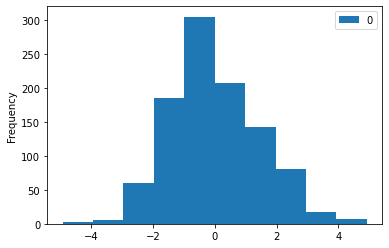

In [50]:
pd.DataFrame(mdf.resid).plot.hist()